# 2021 Fall Semester Project


Samip Singhal


Semi - Supervised Learning Using Graph Neural Networks

References:

https://arxiv.org/pdf/1609.02907.pdf

https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py

https://arxiv.org/abs/2006.12138

https://graphneural.network/datasets/#citation

https://arxiv.org/abs/1706.02216


## Problem Statement


Solve the problem of :-
Classification with ‘high accuracy’ in ‘absence of enough labeled data’

For the purpose of this project, we would like to classify research paper into 7 different classes using only 20 samples for each class.


## Outcome


GCN Outperforms FCNN
FCNN F1 Score - 55%
GCN F1 Score - 76%
The T-SNE Plot of GCN hidden layer representation is much much less scattered as FCNN.
Using only 20 labeled examples for each class , GCN outperforms FCNN by 20%.



In [ ]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCSConv
from spektral.layers import GATConv
from spektral.layers import GraphSageConv
from spektral.layers import GraphConv


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In [2]:
#loading the data

all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

# Parsing the data

In [3]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)


X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Theory', 'Case_Based', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Neural_Networks'}

Number of classes:  7


# Select examples for training, validation, and test then set the mask

In [4]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [5]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

# Data Distribution

In [6]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [7]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [8]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


# Convert the labels to one hot encoding

In [9]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

# Build a graph on NetworkX using the obtained nodes and edges list

In [10]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


# Building and Training Graph Convolutional Networks

In [25]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphSageConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphSageConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphSageConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1433)]       0           []                               
                                                                                                  
 dropout_9 (Dropout)            (None, 1433)         0           ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 2708)]       0           []                               
                                                                                                  
 graph_sage_conv_4 (GraphSageCo  (None, 16)          45856       ['dropout_9[0][0]',              
 nv)                                                              'input_12[0][0]']         

In [26]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.1211 - acc: 0.1214 - val_loss: 0.3488 - val_acc: 0.2920
Epoch 2/200
1/1 [==============================] - 0s 280ms/step - loss: 0.1052 - acc: 0.3143 - val_loss: 0.3400 - val_acc: 0.4100
Epoch 3/200
1/1 [==============================] - 0s 362ms/step - loss: 0.0996 - acc: 0.4500 - val_loss: 0.3298 - val_acc: 0.4580
Epoch 4/200
1/1 [==============================] - 0s 365ms/step - loss: 0.0957 - acc: 0.5500 - val_loss: 0.3175 - val_acc: 0.5260
Epoch 5/200
1/1 [==============================] - 0s 291ms/step - loss: 0.0922 - acc: 0.6714 - val_loss: 0.3094 - val_acc: 0.5780
Epoch 6/200
1/1 [==============================] - 0s 277ms/step - loss: 0.0905 - acc: 0.7500 - val_loss: 0.3043 - val_acc: 0.6440
Epoch 7/200
1/1 [==============================] - 0s 283ms/step - loss: 0.0902 - acc: 0.7571 - val_loss: 0.3019 - val_acc: 0.6700
Epoch 8/200
1/1 [==============================] - 0s 296ms/step - loss: 0.0889 - acc:

In [21]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

ValueError: in user code:

    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 1 of layer "model_2" is incompatible with the layer: expected shape=(None, 2708), found shape=(None, 1000)


# Get hidden layer representation for GCN

In [27]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3])

/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


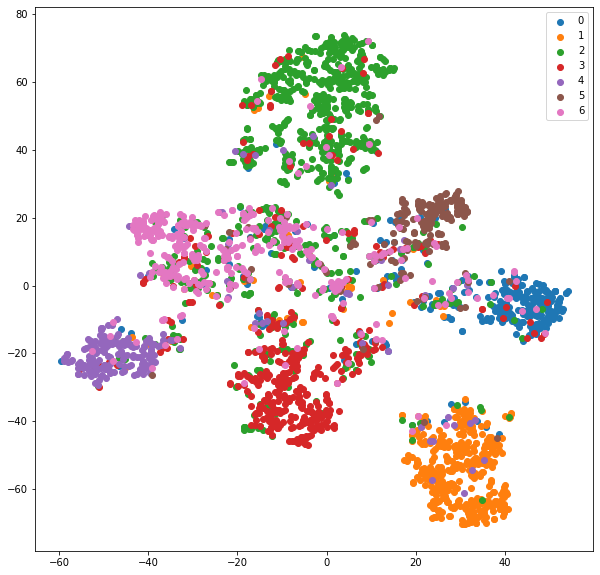

In [28]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

# Comparison to Fully-Connected Neural Networks

In [31]:
es_patience = 10
optimizer = Adam(learning_rate=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 1s 831ms/step - loss: 0.2184 - acc: 0.1643 - val_loss: 0.4328 - val_acc: 0.2680
Epoch 2/200
1/1 [==============================] - 0s 86ms/step - loss: 0.1749 - acc: 0.3571 - val_loss: 0.3976 - val_acc: 0.3640
Epoch 3/200
1/1 [==============================] - 0s 86ms/step - loss: 0.1386 - acc: 0.6143 - val_loss: 0.3607 - val_acc: 0.5480
Epoch 4/200
1/1 [==============================] - 0s 92ms/step - loss: 0.1127 - acc: 0.7000 - val_loss: 0.3231 - val_acc: 0.6040
Epoch 5/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0821 - acc: 0.8071 - val_loss: 0.2881 - val_acc: 0.6120
Epoch 6/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0687 - acc: 0.8286 - val_loss: 0.2614 - val_acc: 0.6080
Epoch 7/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0550 - acc: 0.8786 - val_loss: 0.2545 - val_acc: 0.5960
Epoch 8/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0469 - acc:

In [32]:
# Evaluate model
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.50      0.56      0.53       114
    Genetic_Algorithms       0.75      0.71      0.73       156
       Neural_Networks       0.72      0.54      0.62       290
 Probabilistic_Methods       0.70      0.50      0.58       172
Reinforcement_Learning       0.54      0.52      0.53        85
         Rule_Learning       0.42      0.60      0.49        60
                Theory       0.34      0.60      0.44       123

              accuracy                           0.57      1000
             macro avg       0.57      0.58      0.56      1000
          weighted avg       0.62      0.57      0.58      1000



In [33]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


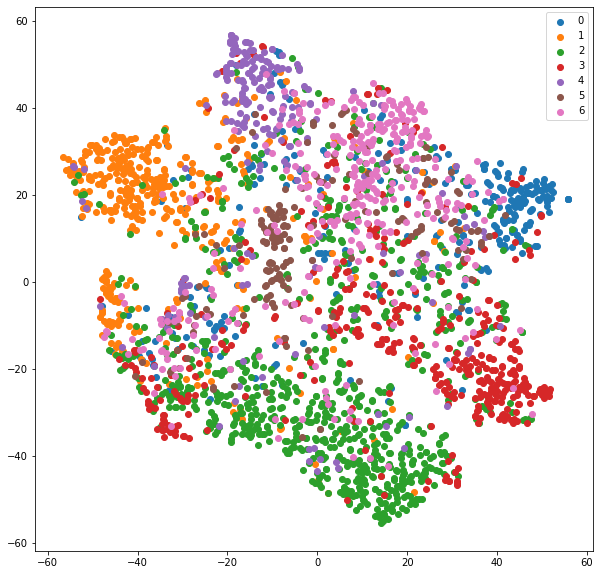

In [34]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)